# Informes y predicciones de COVID-19 en España 

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Pain_Graphs.ipynb).

**Indice**

## [1. Datos de Madrid, hoy](#DatosMadrid)

## 2. Comparativas y predicciones

| Comparativas de dos dimensiones | Comparativas por comunidades  | Comparativas individuales | Predicciones |
| --- | --- | --- |  --- | 
| [Casos Vs fallecidos, historicos](#Comparativa_Casos_Fallecidos) | [Comparativa de fallecidos](#Comunidades_Fallecidos) | [Fallecidos hoy, en España](#Pico_España) | [Predicción de fallecidos, en España](#Prediccion_Fallecidos_España)|
| [Casos Vs fallecidos, hoy](#Comparativa_Casos_Fallecidos_Hoy) |   [Comparativa de fallecidos, hoy](#Comunidades_Fallecidos_Hoy) | [Fallecidos hoy, en Madrid](#Reporte_Fallecidos_hoy_absoluto_Madrid)|  [Predicción de fallecidos, en Madrid](#Prediccion_Fallecidos_hoy_absoluto_Madrid)
| [Casos Vs fallecidos, variación diaria](#Comparativa_Casos_Fallecidos_Variacion_Diaria) |[Comparativa de mortalidad](#Comunidades_Mortalidad)| [Fallecidos hoy, en Cataluña](#Reporte_Fallecidos_hoy_absoluto_Cataluña)|  [Predicción de fallecidos, en Cataluña](#Prediccion_Fallecidos_hoy_absoluto_Cataluña)
|  |  [Comparativa de curados](#Curados)| [Fallecidos hoy, en Castilla y León](#Reporte_Fallecidos_hoy_absoluto_CyL)|[Predicción de fallecidos, en Castilla y León](#Prediccion_Fallecidos_hoy_absoluto_CyL)
|  | | [Fallecidos hoy, en Castilla La Mancha](#Reporte_Fallecidos_hoy_absoluto_CM) |[Predicción de fallecidos, en Castilla La Mancha](#Prediccion_Fallecidos_hoy_absoluto_CM)
|  |  | | |
  



## [3. ¿ Son reales estos datos ?](#Reales)




In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

def Insertar_Enlace(cell_name):
    display(HTML('<a id="'+ cell_name +'"></a>'))

Insertar_Enlace('DatosMadrid')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad.head(10)




,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados hoy absoluto / Casos hoy absoluto,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-05-17,Madrid,66338,128,-77,0.001930,8847,21,4,0.002374,0.133362,40698,112.0,25640,0.875000,3584,42227
2020-05-16,Madrid,66210,205,-107,0.003096,8826,17,-13,0.001926,0.133303,40586,203.0,25624,0.990244,3577,42157
2020-05-15,Madrid,66005,312,-112,0.004727,8809,30,11,0.003406,0.133460,40383,184.0,25622,0.589744,3574,42057
2020-05-14,Madrid,65693,424,127,0.006454,8779,19,-21,0.002164,0.133637,40199,215.0,25494,0.507075,3564,41962
2020-05-13,Madrid,65269,297,178,0.004550,8760,40,3,0.004566,0.134214,39984,233.0,25285,0.784512,3555,41856
2020-05-12,Madrid,64972,119,53,0.001832,8720,37,-2,0.004243,0.134212,39751,147.0,25221,1.235294,3543,41735
2020-05-11,Madrid,64853,66,-198,0.001018,8683,39,-7,0.004492,0.133887,39604,75.0,25249,1.136364,3529,41650
2020-05-10,Madrid,64787,264,74,0.004075,8644,46,0,0.005322,0.133422,39529,302.0,25258,1.143939,3520,41559
2020-05-09,Madrid,64523,190,-273,0.002945,8598,46,-2,0.005350,0.133255,39227,252.0,25296,1.326316,3508,41436


In [2]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos,media_movil ):
    array = []
    dias_a_considerar = 4 if media_movil else 1
    for ca in COMUNIDADES: 
        
        comunidad = Loading_data.Get_Comunidad(ca).head(dias_a_considerar)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        if media_movil : comunidad = pd.DataFrame(comunidad.mean(axis=0)).T 
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [3]:
import scipy.stats as spstats
from matplotlib import pyplot as plt    


def Print_Two_Cordinates_CCAA(df, add_LR=False):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    
    if add_LR:
        slope, intercept, r_value, p_value, std_err = spstats.linregress(df[df.columns[1]], df[df.columns[2]])
        plt.plot(df[df.columns[1]], intercept + slope*df[df.columns[1]], 'r', label='fitted line')
        #.format(round(slope, 2),round(intercept, 2),round(r_value, 2))
        note2add = f"""slope: {slope:12.4f}\nintercept: {intercept:8.2f}\nr2: {r_value**2:15.4f}"""
        plt.annotate(note2add,xy=(0.7,0.3), xycoords='figure fraction')
        
    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    
    return plt


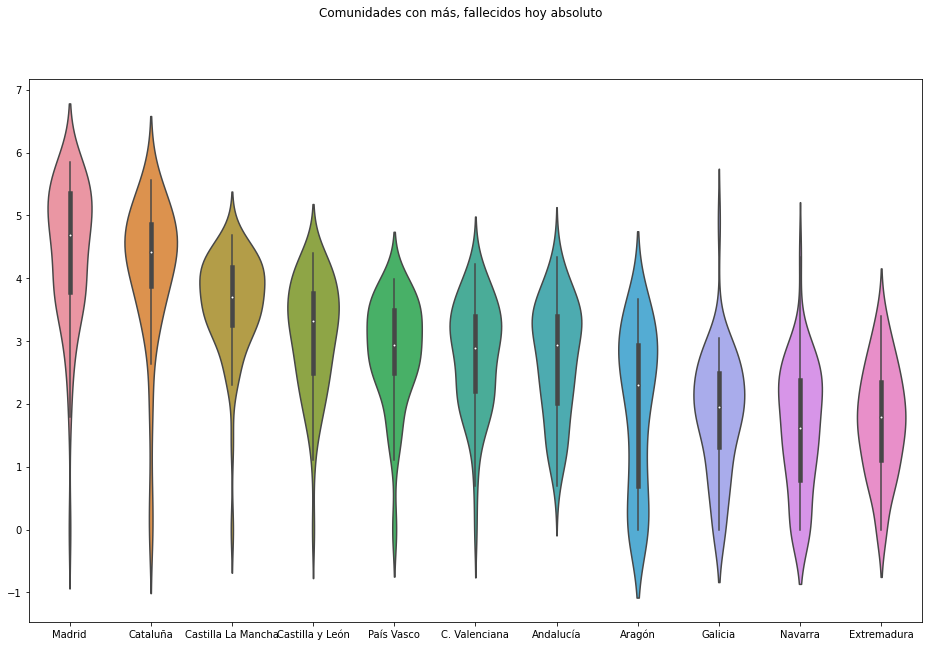

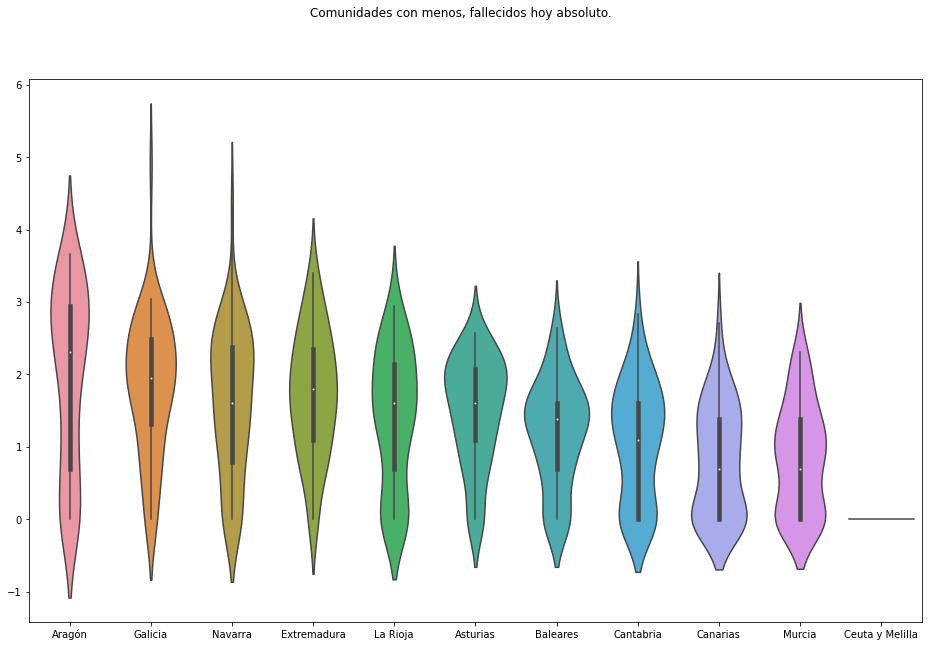

In [4]:
import numpy as np 
import seaborn as sns

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Single_Dimension(dimension ):
    df = pd.DataFrame()
    df_tmp = pd.DataFrame()
    array = []
    #
    for ca in COMUNIDADES:
        df_tmp = Loading_data.Get_Comunidad(ca)
        new = df_tmp[[dimension]].copy()
        new.rename(columns={dimension: ca}, inplace=True)
        array.append(new)
    #
    df =  pd.concat(array, axis=1)
    return df

def plot_violin(dimension):
    """ Muestra la distribucion logaritmica por comunidades, de una dimension"""
    df = Get_Single_Dimension(dimension) 
    # Ordenamos comunidades 
    s = df.sum()
    df = df[s.sort_values(ascending=False).index[:]]

    # Pasamos a logaritmo
    df2 = np.log(df)
    df2.replace(-np.inf,  np.nan, inplace=True)
    display(HTML("<h2>Comparativa de distribucion de '" +dimension+ "', en cada CC.AA </h2>"))
    display(HTML("Distribuciones convertidas a logaritmos neperianos, para facilitar la comparación."))

    # primer grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con más, " + dimension.lower())
    sns.violinplot(data=df2.iloc[:,:-7])

    #segundo grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con menos, " + dimension.lower()+".")
    sns.violinplot(data=df2.iloc[:,7:])
    return df

dimension = 'Fallecidos hoy absoluto'
df = plot_violin(dimension)


In [5]:
df

,Madrid,Cataluña,Castilla La Mancha,Castilla y León,País Vasco,C. Valenciana,Andalucía,Aragón,Galicia,Navarra,Extremadura,La Rioja,Asturias,Baleares,Cantabria,Canarias,Murcia,Ceuta y Melilla
Fecha,,,,,,,,,,,,,,,,,,
2020-05-17,21,29,10,6,4,1,3,0,2,2,3,1,2,2,1,0,0,0
2020-05-16,17,33,13,10,1,7,11,1,3,1,3,0,3,0,0,0,1,0
2020-05-15,30,59,18,5,0,9,8,1,0,2,2,0,2,0,1,0,1,0
2020-05-14,19,131,17,6,12,8,4,7,4,4,3,0,1,1,0,0,0,0
2020-05-13,40,71,24,5,13,5,6,1,2,1,2,1,3,5,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11,10,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2020-03-10,13,2,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0
2020-03-09,6,1,0,0,5,0,0,0,0,0,0,-1,0,0,0,0,0,0


In [6]:


import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Comparar_Dos_Dimensiones(Atributos, media_movil=False, add_LR=False ):
    """ Compara dos dimensiones de atributos, Ma indica si hacerlo con la media movil"""
    
    df = Get_Dimensions_All_CCAA(Atributos,media_movil )
    df = df.sort_values(by=[df.columns[1],df.columns[2]])
    plt = Print_Two_Cordinates_CCAA(df, add_LR)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.set_index('Lugar').to_html(index=True)))
    return 

  

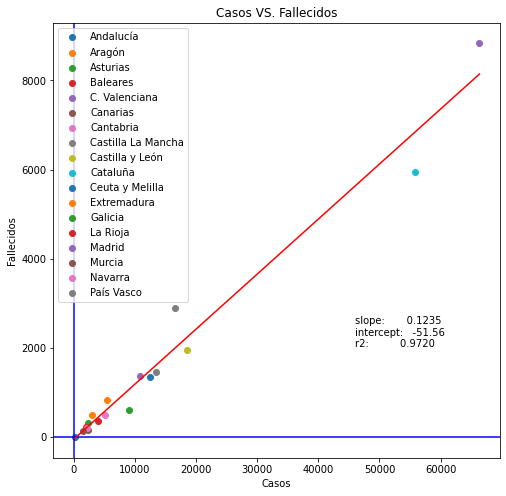

Total: Casos 231350
Total: Fallecidos 27650


,Casos,Fallecidos
Lugar,,
Ceuta y Melilla,237,6
Murcia,1551,144
Baleares,1991,218
Cantabria,2268,207
Canarias,2289,151
Asturias,2366,315
Extremadura,2947,500
La Rioja,4024,349
Navarra,5148,503


In [7]:
Insertar_Enlace("Comparativa_Casos_Fallecidos")
Comparar_Dos_Dimensiones(['Casos', 'Fallecidos'],add_LR=True )  


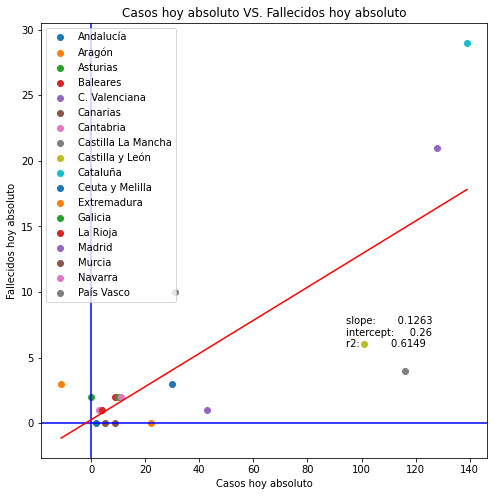

Total: Casos hoy absoluto 652
Total: Fallecidos hoy absoluto 87


,Casos hoy absoluto,Fallecidos hoy absoluto
Lugar,,
Extremadura,-11,3
Asturias,0,2
Ceuta y Melilla,2,0
Cantabria,3,1
La Rioja,4,1
Canarias,5,0
Murcia,9,0
Baleares,9,2
Galicia,10,2


In [8]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Hoy")

Comparar_Dos_Dimensiones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'],add_LR=True )   

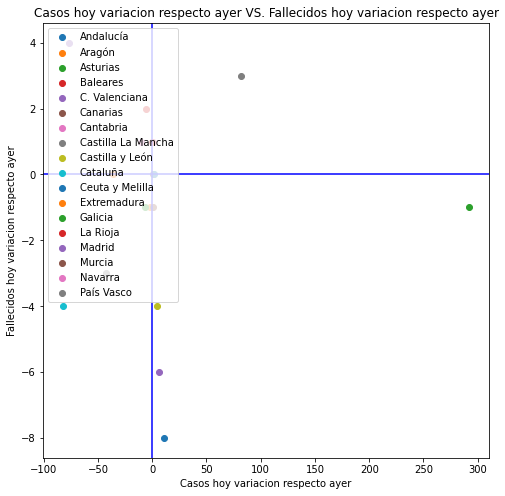

Total: Casos hoy variacion respecto ayer 137
Total: Fallecidos hoy variacion respecto ayer -17


,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
Lugar,,
Cataluña,-82,-4
Madrid,-77,4
Castilla La Mancha,-43,-3
Extremadura,-36,0
Navarra,-10,1
Asturias,-7,-1
Baleares,-6,2
Aragón,-2,-1
La Rioja,0,1


In [9]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Variacion_Diaria")

Comparar_Dos_Dimensiones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [10]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension,include_nation=False):
    def Do_Stuff_to_DF(df):
        df = df.sort_values(by='Fecha')
        # df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        return df
        
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = Do_Stuff_to_DF(df)
        dimension_df[ca] = df[Dimension]
    if include_nation:
        df = Loading_data.Get_Nacion()
        df = Do_Stuff_to_DF(df)
        dimension_df['TOTAL'] = df[Dimension]
        
    return dimension_df 


In [11]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df = short_df.sort_values(by=(short_df.columns[0]))
    short_df.columns = [Dimension]

    #mean_y = short_df.median(axis=1)[0]
    #mean_y= df.tail(1).T.median().values[0]
    median_y= df.tail(1).T.drop(axis=0,labels=(['TOTAL'] if 'TOTAL' in short_df.index else [])).median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(median_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(median_y, 2)),
            xy=(8.5, median_y),
            xycoords='data',
            xytext=(-50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    fig.suptitle('Comparativa de: '+Dimension, fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension,include_nation=False):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension,include_nation)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 

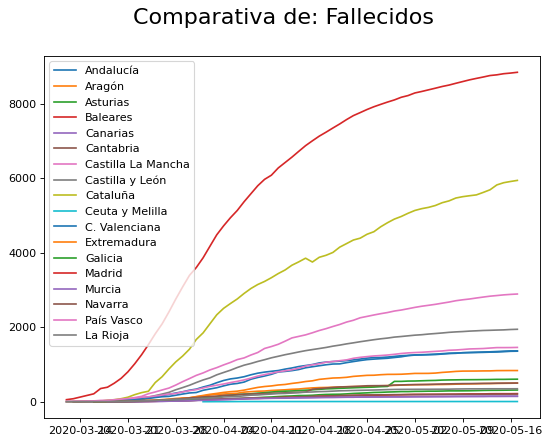

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
2020-03-16,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
2020-03-17,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
2020-03-18,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
2020-03-19,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
2020-03-20,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
2020-03-21,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
2020-03-22,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18


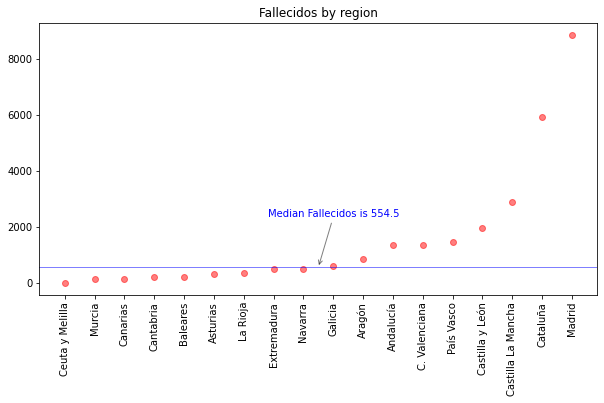

In [12]:
Insertar_Enlace("Comunidades_Fallecidos")
Report_Location("Fallecidos")

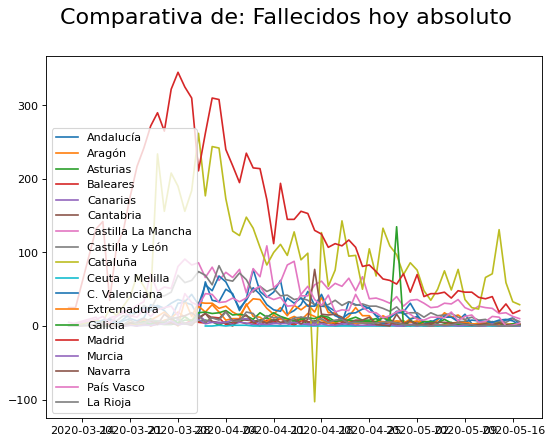

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
2020-03-16,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
2020-03-17,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
2020-03-18,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
2020-03-19,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
2020-03-20,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
2020-03-21,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
2020-03-22,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3


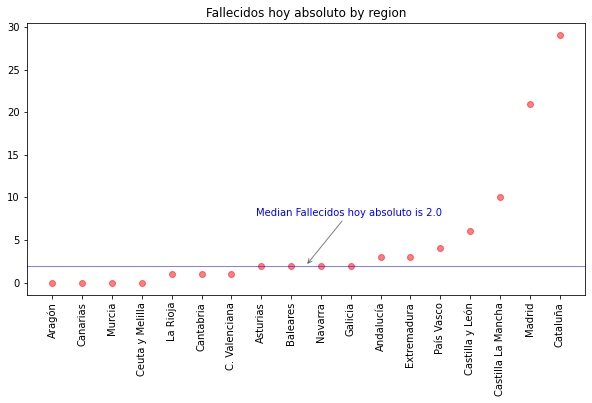

In [13]:
Insertar_Enlace("Comunidades_Fallecidos_Hoy")

Report_Location("Fallecidos hoy absoluto") 

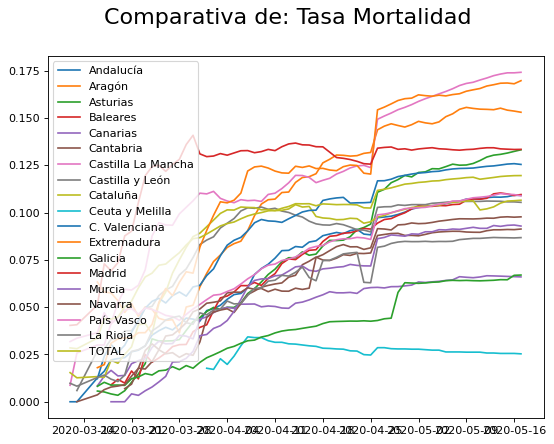

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756,0.028475
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230,0.028035
2020-03-16,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821,0.033620
2020-03-17,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085,0.043926
2020-03-18,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933,0.043599
2020-03-19,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684,0.044731
2020-03-20,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085,0.050150
2020-03-21,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596,0.053197
2020-03-22,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523,0.060199


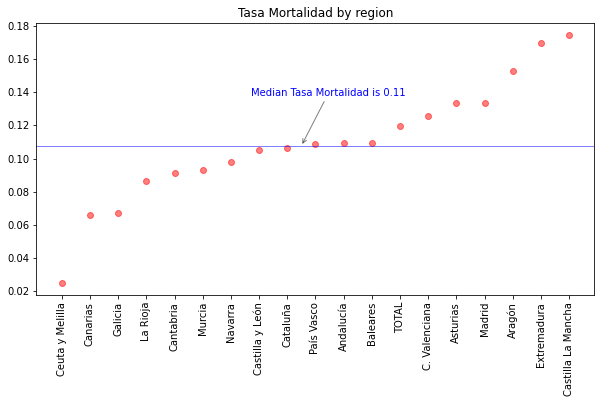

In [14]:
Insertar_Enlace("Comunidades_Mortalidad")

Report_Location("Tasa Mortalidad",True)

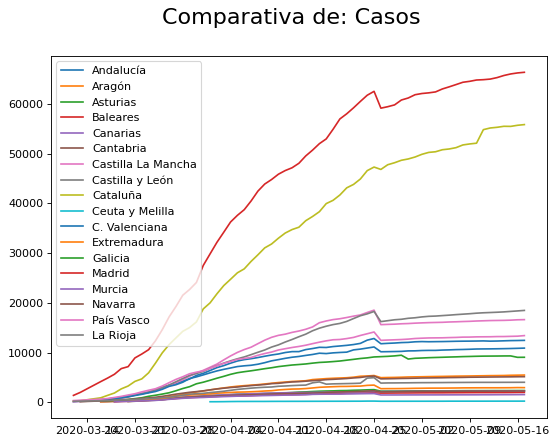

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
2020-03-13,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
2020-03-16,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
2020-03-17,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
2020-03-18,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
2020-03-19,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
2020-03-20,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
2020-03-21,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
2020-03-22,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654


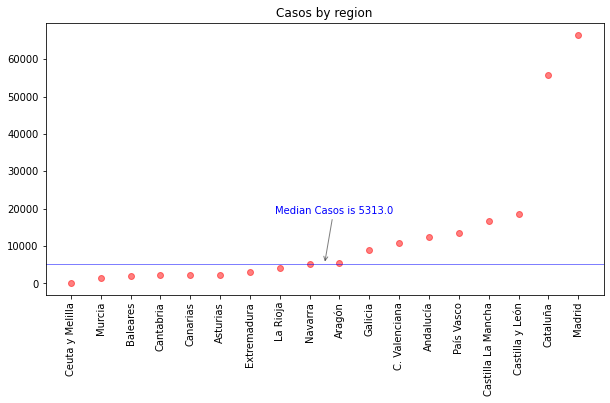

In [15]:
Insertar_Enlace("Comunidades_Casos")

Report_Location("Casos") 

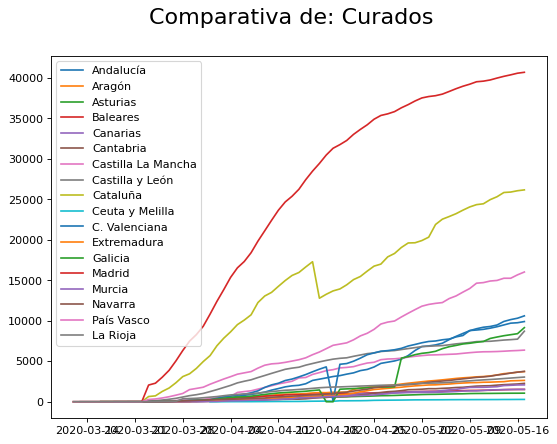

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
2020-03-16,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-17,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-18,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-19,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-21,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-22,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0


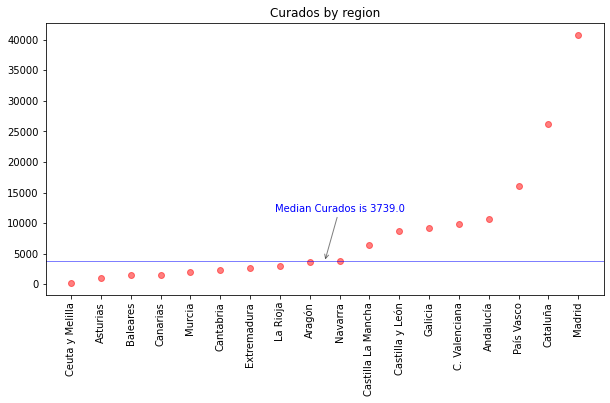

In [16]:
Insertar_Enlace("Curados")

Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
Fecha,,,,
2020-03-12,74,NaN,NaN,NaN
2020-03-13,107,33.0,NaN,NaN
2020-03-16,308,201.0,NaN,NaN
2020-03-17,490,182.0,NaN,NaN
2020-03-18,597,107.0,130.75,NaN
...,...,...,...,...
2020-05-13,27104,184.0,156.50,1.25
2020-05-14,27321,217.0,175.00,18.50
2020-05-15,27459,138.0,178.75,3.75


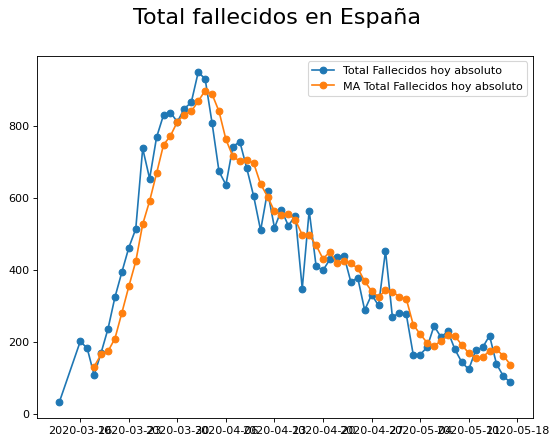

In [17]:
# Casos totales españa, evolucion
import Loading_data 

MOVING_AVERAGE_WINDOW=4

def get_fallecidos_nacion(window_size=MOVING_AVERAGE_WINDOW):
    Dimension = 'Fallecidos'
    
    Insertar_Enlace("Pico_España")

    df = Get_Dimension_CCAA(Dimension)

    df['Total Fallecidos'] = df.sum(axis=1)
    df['Total Fallecidos']

    CONVERT_INT_COLUMNS = ['Total Fallecidos']
    for column in CONVERT_INT_COLUMNS :
        df[column] = df[column].fillna(0)
        df[column] = df[column].astype(np.int64)

    df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
    df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=window_size).mean()

    df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)
    return df

df = get_fallecidos_nacion()
df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,126.661986,14.615591,176.191630,126.661986,126.661986,-32.610615,-32.610615,-32.610615,-32.610615,-32.610615,-32.610615,0.0,0.0,0.0,94.051371
2,2020-03-17,178.471629,97.618983,255.889139,178.471629,178.471629,-2.572371,-2.572371,-2.572371,-2.572371,-2.572371,-2.572371,0.0,0.0,0.0,175.899258
3,2020-03-18,230.281273,190.569857,344.802218,230.281273,230.281273,38.703162,38.703162,38.703162,38.703162,38.703162,38.703162,0.0,0.0,0.0,268.984435
4,2020-03-19,282.090916,222.400492,382.056300,282.090916,282.090916,21.957759,21.957759,21.957759,21.957759,21.957759,21.957759,0.0,0.0,0.0,304.048675
5,2020-03-20,333.900560,259.677281,417.409392,333.900560,333.900560,3.068474,3.068474,3.068474,3.068474,3.068474,3.068474,0.0,0.0,0.0,336.969034
6,2020-03-21,385.710203,312.137309,467.832583,385.710203,385.710203,5.260001,5.260001,5.260001,5.260001,5.260001,5.260001,0.0,0.0,0.0,390.970204
7,2020-03-22,437.519847,321.954661,483.612750,437.519847,437.519847,-33.806411,-33.806411,-33.806411,-33.806411,-33.806411,-33.806411,0.0,0.0,0.0,403.713436
8,2020-03-23,489.329490,376.963981,529.221639,489.329490,489.329490,-32.610615,-32.610615,-32.610615,-32.610615,-32.610615,-32.610615,0.0,0.0,0.0,456.718876
9,2020-03-24,541.139134,462.270544,617.603035,541.139134,541.139134,-2.572371,-2.572371,-2.572371,-2.572371,-2.572371,-2.572371,0.0,0.0,0.0,538.566763
10,2020-03-25,592.948777,553.963654,713.999974,592.948777,592.948777,38.703162,38.703162,38.703162,38.703162,38.703162,38.703162,0.0,0.0,0.0,631.651940


Prediccion total para Total Fallecidos hoy absoluto : 27839.178778902577


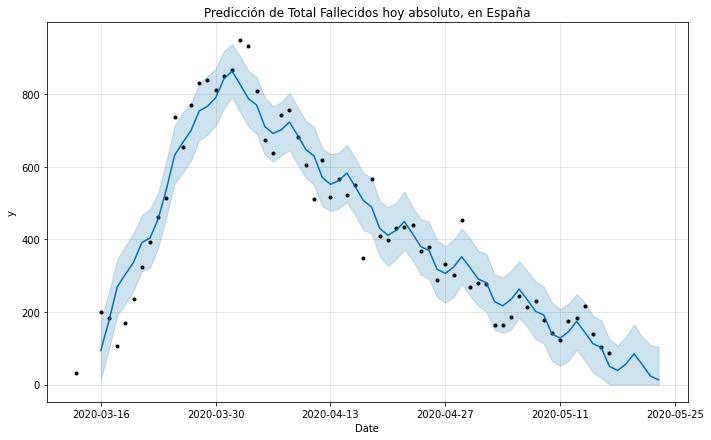

In [18]:
import fbprophet
def Get_Prediction_Nacion(df,dimension,location='España' , link=None) :
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()
    df.columns = ['ds','y']


    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    df_prophet.fit(df)

    # Make a future dataframe for 2 years
    df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
    # Make predictions
    df_forecast = df_prophet.predict(df_forecast)
    df_forecast

    df_forecast = df_forecast[df_forecast["yhat"] >= 0]
    df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0
    
    if link is not None:
        Insertar_Enlace(link)

    df_prophet.plot(df_forecast, xlabel = 'Date' )
    plt.title('Predicción de ' + dimension + ", en " + location )

    suma = df_forecast.trend.sum()
    display(HTML(pd.DataFrame(df_forecast).to_html()))

    print ("Prediccion total para " + dimension + " : " + str(suma) )
    return df_forecast
    
    
Insertar_Enlace("Prediccion_Fallecidos_España")
    
prediccion = Get_Prediction_Nacion( df = get_fallecidos_nacion(), 
                                   dimension = 'Total Fallecidos hoy absoluto')

In [19]:
def Get_Predictions_Compare(df,dimension,location='España' , link=None) :
    if link is not None:
        Insertar_Enlace(link)


    display(HTML("<h2>Comparativa de predicciones, hoy contra días pasados, " +dimension+ " en " +  location+ "</h2>"))

        
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()

    df.columns = ['ds','y']
    
    df_original = df.copy()

    
    results = pd.DataFrame()
    array_results_temp = []
    for i in range(4):
        
        if i >= 1 : df = df.iloc[1:]
    
        fecha=max(df.ds)
        fecha_short = str(fecha)[:10]
        

        df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
        df_prophet.fit(df)

        # Make a future dataframe 
        df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
        # Make predictions
        df_forecast = df_prophet.predict(df_forecast)
        suma = df_forecast.yhat.sum()
            
        title_column = "Predicción con los datos de " + fecha_short
        df_forecast[title_column] = df_forecast.yhat
        
        array_results_temp.append(pd.DataFrame(df_forecast[['ds',title_column]]))


    df_1 = pd.merge(array_results_temp[0], array_results_temp[1], how ='outer', on ='ds') 
    df_2 = pd.merge(df_1                 , array_results_temp[2], how ='outer', on ='ds') 
    df_3 = pd.merge(df_2                 , array_results_temp[3], how ='outer', on ='ds') 
    df_4 = pd.merge(df_3                 , df_original          , how ='outer', on ='ds') 
    df_4['datos reales'] = df_4['y']
    del df_4['y']

        
    df_chart = df_4
    df_chart = df_chart.set_index('ds')
    df_chart = df_chart.head(70).tail(40)

    for c in df_chart.columns: 
        df_chart.loc[df_chart[c] < 0, c] = 0

    df_chart.drop(df_chart.loc[df_chart.sum(axis=1)==0].index, inplace=True)
    df_chart.drop(columns=df_chart.columns[df_chart.sum()==0], inplace=True)


    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df_chart) 
    plt.title("Predicciones en días anteriores Vs. Datos reales" + dimension +", en " + location )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=90)
    plt.legend(df_chart.columns)



    #print(df_chart)

    print("Las predicciones del total de "+ dimension+  " en " +  location+  ", cambian dia a dia")
    print(df_chart.sum(axis=0) )

    return df_chart



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en España, cambian dia a dia
Predicción con los datos de 2020-05-17    10595.451289
Predicción con los datos de 2020-05-16    10470.287670
Predicción con los datos de 2020-05-15    10479.976615
Predicción con los datos de 2020-05-14    10377.582700
datos reales                              10161.000000
dtype: float64


,Predicción con los datos de 2020-05-17,Predicción con los datos de 2020-05-16,Predicción con los datos de 2020-05-15,Predicción con los datos de 2020-05-14,datos reales
ds,,,,,
2020-04-14,561.481797,562.925853,561.889391,563.738065,567.0
2020-04-15,582.732532,584.037231,582.383714,584.763114,523.0
2020-04-16,545.962330,547.161291,545.627238,548.414573,551.0
2020-04-17,507.058232,505.430038,506.445983,505.060009,348.0
2020-04-18,489.234945,490.643120,488.024414,490.623220,565.0
2020-04-19,430.166161,426.925664,424.919227,427.763525,410.0
2020-04-20,411.359585,407.658868,407.551489,410.514703,399.0
2020-04-21,424.560773,415.443010,427.363139,429.164469,430.0
2020-04-22,448.999250,444.432824,453.729127,454.369688,435.0


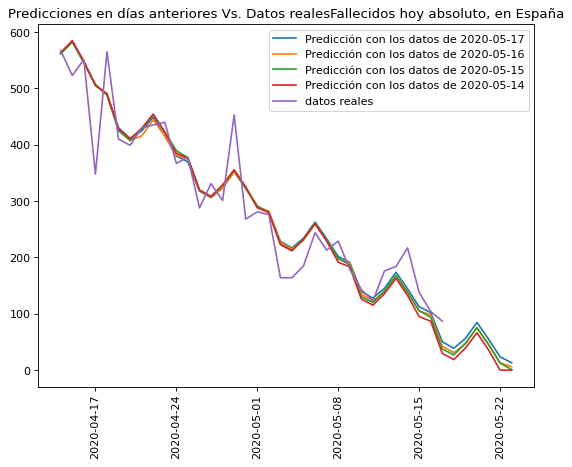

In [20]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'España'

link="Prediccion_Fallecidos_hoy_absoluto_España"


df = get_fallecidos_nacion()[['Total Fallecidos hoy absoluto']] 
df.columns = [ 'Fallecidos hoy absoluto' ]
df.sort_index(inplace=True,ascending=False)

prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

In [21]:
MOVING_AVERAGE_WINDOW = 4
def report_single_location_single_dimension(location,dimension,window_size=MOVING_AVERAGE_WINDOW):
    
    Dimension = 'Fallecidos'
    labelMa = f'Moving Average ({window_size}) {dimension}'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df[labelMa] = df[dimension].rolling(window=window_size).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.title("Gráfico de " + dimension +", en " + location)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,25,NaN
2020-03-13,25,NaN
2020-03-16,132,NaN
2020-03-17,142,81.00
2020-03-18,35,83.50
2020-03-19,108,104.25
2020-03-20,130,103.75
2020-03-21,176,112.25
2020-03-22,217,157.75


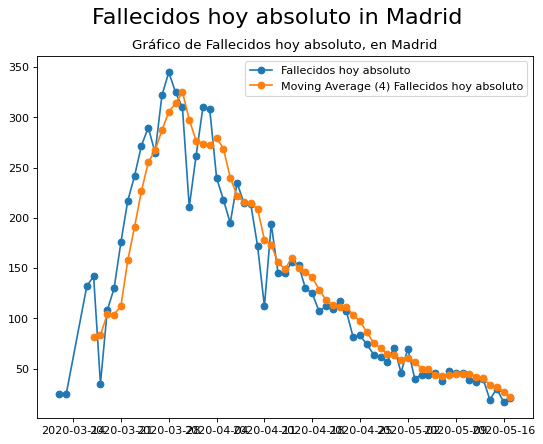

In [22]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Madrid")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-09,-0.278962,0.000000,38.893519,-0.278962,-0.278962,1.380235,1.380235,1.380235,1.380235,1.380235,1.380235,0.0,0.0,0.0,1.101272
2,2020-03-10,15.667672,0.000000,51.961111,15.667672,15.667672,-1.515243,-1.515243,-1.515243,-1.515243,-1.515243,-1.515243,0.0,0.0,0.0,14.152429
3,2020-03-11,31.614306,0.000000,61.351765,31.614306,31.614306,-6.710873,-6.710873,-6.710873,-6.710873,-6.710873,-6.710873,0.0,0.0,0.0,24.903433
4,2020-03-12,47.560940,11.896628,85.154987,47.560940,47.560940,0.493304,0.493304,0.493304,0.493304,0.493304,0.493304,0.0,0.0,0.0,48.054244
5,2020-03-13,63.507574,27.942072,104.082378,63.507574,63.507574,2.372056,2.372056,2.372056,2.372056,2.372056,2.372056,0.0,0.0,0.0,65.879631
6,2020-03-16,111.347477,76.411511,150.763646,111.347477,111.347477,1.380235,1.380235,1.380235,1.380235,1.380235,1.380235,0.0,0.0,0.0,112.727712
7,2020-03-17,127.294111,91.503166,159.751992,127.294111,127.294111,-1.515243,-1.515243,-1.515243,-1.515243,-1.515243,-1.515243,0.0,0.0,0.0,125.778869
8,2020-03-18,143.240746,97.143342,175.385478,143.240746,143.240746,-6.710873,-6.710873,-6.710873,-6.710873,-6.710873,-6.710873,0.0,0.0,0.0,136.529873
9,2020-03-19,159.187381,123.363907,197.901967,159.187381,159.187381,0.493304,0.493304,0.493304,0.493304,0.493304,0.493304,0.0,0.0,0.0,159.680684
10,2020-03-20,175.134015,139.887980,213.812924,175.134015,175.134015,2.372056,2.372056,2.372056,2.372056,2.372056,2.372056,0.0,0.0,0.0,177.506071


Prediccion total para Fallecidos hoy absoluto : 8900.293521183405


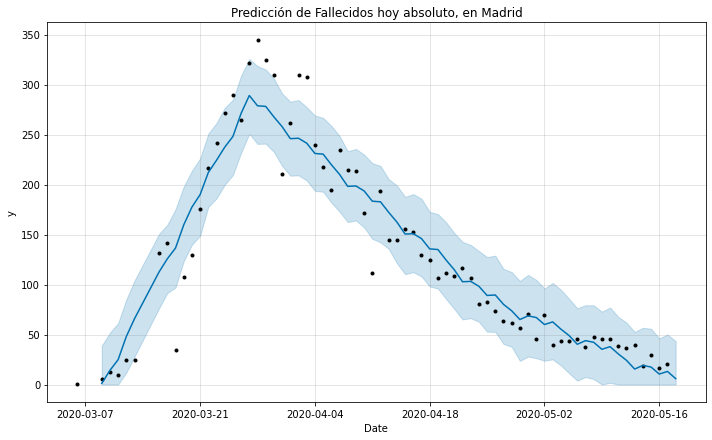

In [23]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

link="Prediccion_Fallecidos_hoy_absoluto_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Madrid, cambian dia a dia
Predicción con los datos de 2020-05-17    3452.232481
Predicción con los datos de 2020-05-16    3431.743811
Predicción con los datos de 2020-05-15    3420.083028
Predicción con los datos de 2020-05-14    3402.222683
datos reales                              3261.000000
dtype: float64


,Predicción con los datos de 2020-05-17,Predicción con los datos de 2020-05-16,Predicción con los datos de 2020-05-15,Predicción con los datos de 2020-05-14,datos reales
ds,,,,,
2020-04-09,198.646483,202.168393,202.511347,204.188380,214.0
2020-04-10,193.707119,196.627547,197.059798,197.074564,172.0
2020-04-11,183.417279,185.900322,185.528912,185.529210,112.0
2020-04-12,182.779017,183.208835,183.328234,184.823249,194.0
2020-04-13,172.260947,173.188690,173.455251,174.843333,145.0
2020-04-14,162.547353,163.346016,163.724762,165.171527,145.0
2020-04-15,150.534820,151.203180,151.694659,153.200806,156.0
2020-04-16,150.922095,151.462879,152.064650,153.629891,153.0
2020-04-17,145.984200,145.927237,146.615423,146.577231,130.0


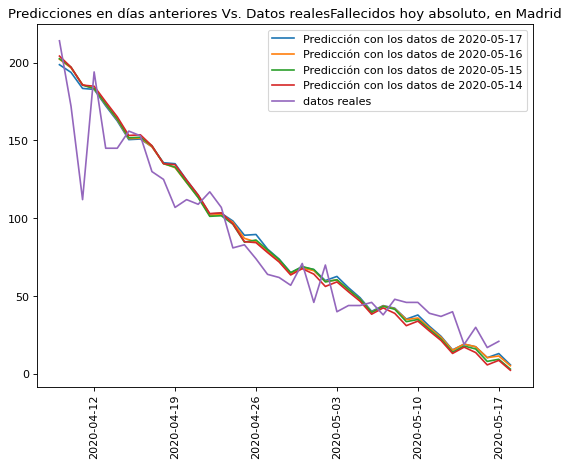

In [24]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,0,NaN
2020-03-16,8,NaN
2020-03-17,6,3.75
2020-03-18,23,9.25
2020-03-19,14,12.75
2020-03-20,27,17.50
2020-03-21,40,26.00
2020-03-22,69,37.50


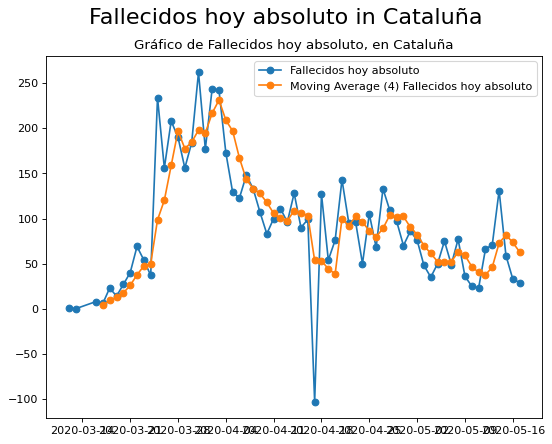

In [25]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Cataluña")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-10,-1.056515,0.000000,53.400489,-1.056515,-1.056515,6.483537,6.483537,6.483537,6.483537,6.483537,6.483537,0.0,0.0,0.0,5.427023
2,2020-03-12,14.006759,0.000000,73.155082,14.006759,14.006759,7.074105,7.074105,7.074105,7.074105,7.074105,7.074105,0.0,0.0,0.0,21.080864
3,2020-03-16,44.133307,0.000000,79.794800,44.133307,44.133307,-13.808450,-13.808450,-13.808450,-13.808450,-13.808450,-13.808450,0.0,0.0,0.0,30.324857
4,2020-03-17,51.664944,10.219378,107.390615,51.664944,51.664944,6.483537,6.483537,6.483537,6.483537,6.483537,6.483537,0.0,0.0,0.0,58.148481
5,2020-03-18,59.196580,22.680376,121.968326,59.196580,59.196580,12.251402,12.251402,12.251402,12.251402,12.251402,12.251402,0.0,0.0,0.0,71.447982
6,2020-03-19,66.728217,22.533467,122.925639,66.728217,66.728217,7.074105,7.074105,7.074105,7.074105,7.074105,7.074105,0.0,0.0,0.0,73.802322
7,2020-03-20,74.259854,34.459356,129.773614,74.259854,74.259854,8.339794,8.339794,8.339794,8.339794,8.339794,8.339794,0.0,0.0,0.0,82.599648
8,2020-03-21,81.791491,31.783777,131.713132,81.791491,81.791491,0.302582,0.302582,0.302582,0.302582,0.302582,0.302582,0.0,0.0,0.0,82.094073
9,2020-03-22,89.323128,19.505678,117.569803,89.323128,89.323128,-20.642971,-20.642971,-20.642971,-20.642971,-20.642971,-20.642971,0.0,0.0,0.0,68.680156
10,2020-03-23,96.854765,32.634854,135.215718,96.854765,96.854765,-13.808450,-13.808450,-13.808450,-13.808450,-13.808450,-13.808450,0.0,0.0,0.0,83.046315


Prediccion total para Fallecidos hoy absoluto : 6336.26411617037


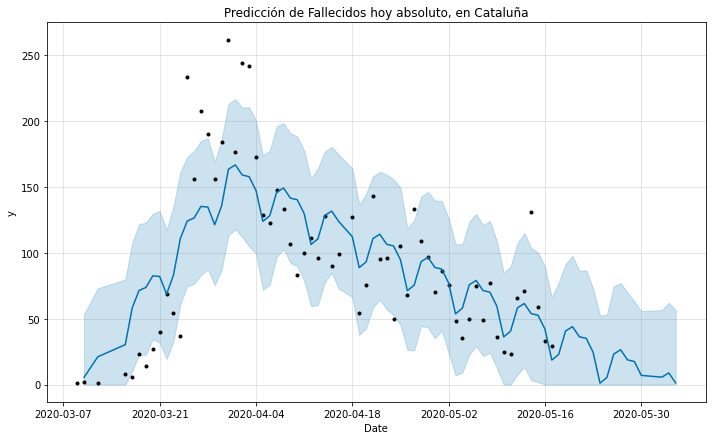

In [26]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'
link="Prediccion_Fallecidos_hoy_absoluto_Cataluña"


prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR)
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,NaN,NaN
2020-03-13,1.0,NaN
2020-03-16,8.0,NaN
2020-03-17,3.0,NaN
2020-03-18,10.0,5.50
2020-03-19,7.0,7.00
2020-03-20,14.0,8.50
2020-03-21,12.0,10.75
2020-03-22,19.0,13.00


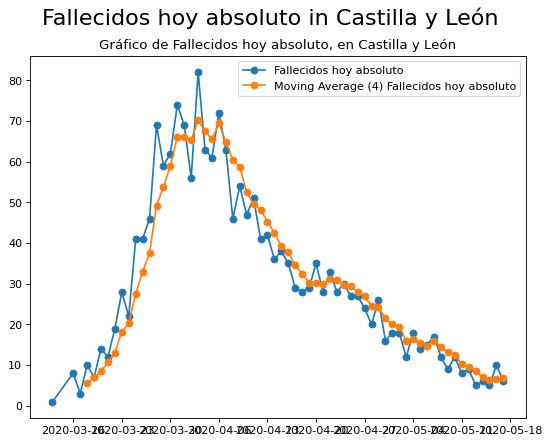

In [27]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla y León',dimension)

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CyL")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,2.319238,0.000000,12.131296,2.319238,2.319238,2.276879,2.276879,2.276879,2.276879,2.276879,2.276879,0.0,0.0,0.0,4.596117
2,2020-03-17,6.391666,0.000000,12.619187,6.391666,6.391666,-1.275095,-1.275095,-1.275095,-1.275095,-1.275095,-1.275095,0.0,0.0,0.0,5.116571
3,2020-03-18,10.464093,3.333172,17.938057,10.464093,10.464093,0.201442,0.201442,0.201442,0.201442,0.201442,0.201442,0.0,0.0,0.0,10.665535
4,2020-03-19,14.536520,5.303964,19.136754,14.536520,14.536520,-2.433136,-2.433136,-2.433136,-2.433136,-2.433136,-2.433136,0.0,0.0,0.0,12.103384
5,2020-03-20,18.608947,13.057223,27.153235,18.608947,18.608947,1.401029,1.401029,1.401029,1.401029,1.401029,1.401029,0.0,0.0,0.0,20.009976
6,2020-03-21,22.681374,16.407921,30.954893,22.681374,22.681374,1.013656,1.013656,1.013656,1.013656,1.013656,1.013656,0.0,0.0,0.0,23.695031
7,2020-03-22,26.753801,18.309034,33.201536,26.753801,26.753801,-1.184775,-1.184775,-1.184775,-1.184775,-1.184775,-1.184775,0.0,0.0,0.0,25.569026
8,2020-03-23,30.826229,25.250496,40.391241,30.826229,30.826229,2.276879,2.276879,2.276879,2.276879,2.276879,2.276879,0.0,0.0,0.0,33.103108
9,2020-03-24,34.898656,26.405949,40.689127,34.898656,34.898656,-1.275095,-1.275095,-1.275095,-1.275095,-1.275095,-1.275095,0.0,0.0,0.0,33.623561
10,2020-03-25,38.971083,31.630091,46.748940,38.971083,38.971083,0.201442,0.201442,0.201442,0.201442,0.201442,0.201442,0.0,0.0,0.0,39.172525


Prediccion total para Fallecidos hoy absoluto : 1955.762376253967


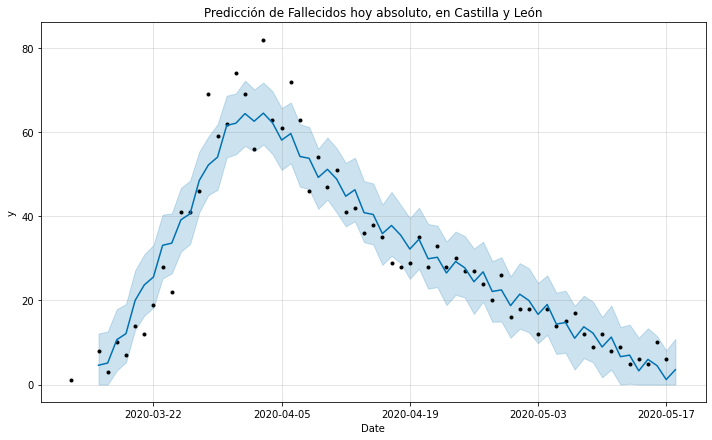

In [28]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla y León'
link="Prediccion_Fallecidos_hoy_absoluto_CyL"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,4,NaN
2020-03-16,12,NaN
2020-03-17,0,4.25
2020-03-18,11,6.75
2020-03-19,14,9.25
2020-03-20,20,11.25
2020-03-21,22,16.75
2020-03-22,28,21.00


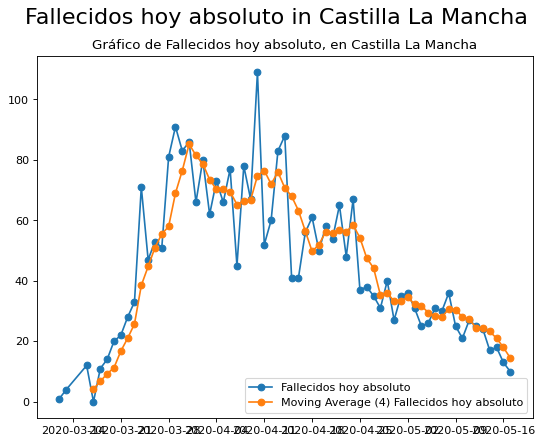

In [29]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)
Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CM")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-13,3.556475,0.000000,22.176350,3.556475,3.556475,3.685145,3.685145,3.685145,3.685145,3.685145,3.685145,0.0,0.0,0.0,7.241620
2,2020-03-16,15.533189,1.572676,33.109709,15.533189,15.533189,2.067625,2.067625,2.067625,2.067625,2.067625,2.067625,0.0,0.0,0.0,17.600814
3,2020-03-18,23.517666,7.109218,36.727869,23.517666,23.517666,-1.443509,-1.443509,-1.443509,-1.443509,-1.443509,-1.443509,0.0,0.0,0.0,22.074156
4,2020-03-19,27.509904,9.048755,39.159777,27.509904,27.509904,-3.835915,-3.835915,-3.835915,-3.835915,-3.835915,-3.835915,0.0,0.0,0.0,23.673989
5,2020-03-20,31.502142,20.404242,50.043198,31.502142,31.502142,3.685145,3.685145,3.685145,3.685145,3.685145,3.685145,0.0,0.0,0.0,35.187287
6,2020-03-21,35.494380,19.079645,48.389100,35.494380,35.494380,-1.925019,-1.925019,-1.925019,-1.925019,-1.925019,-1.925019,0.0,0.0,0.0,33.569361
7,2020-03-22,39.486618,21.614056,51.179705,39.486618,39.486618,-2.340666,-2.340666,-2.340666,-2.340666,-2.340666,-2.340666,0.0,0.0,0.0,37.145952
8,2020-03-23,43.478856,30.600910,60.794401,43.478856,43.478856,2.067625,2.067625,2.067625,2.067625,2.067625,2.067625,0.0,0.0,0.0,45.546481
9,2020-03-24,47.471083,37.498892,67.166476,47.471083,47.471083,3.792341,3.792341,3.792341,3.792341,3.792341,3.792341,0.0,0.0,0.0,51.263424
10,2020-03-25,51.463310,35.295990,64.990945,51.463310,51.463310,-1.443509,-1.443509,-1.443509,-1.443509,-1.443509,-1.443509,0.0,0.0,0.0,50.019800


Prediccion total para Fallecidos hoy absoluto : 2953.823120035424


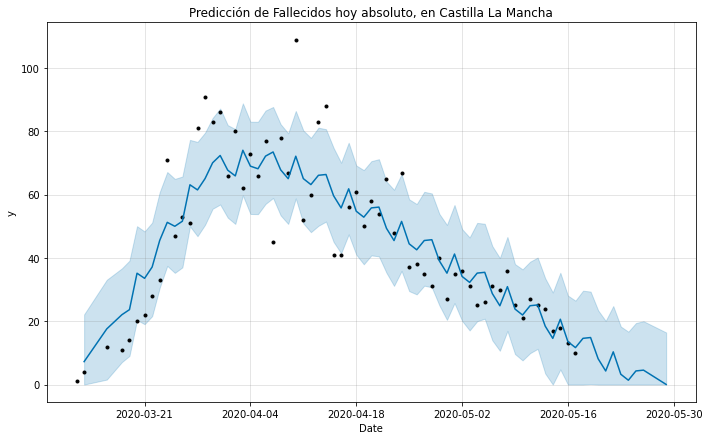

In [30]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Fallecidos_hoy_absoluto_CM"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Castilla La Mancha, cambian dia a dia
Predicción con los datos de 2020-05-17    1355.736857
Predicción con los datos de 2020-05-16    1358.431702
Predicción con los datos de 2020-05-15    1361.071759
Predicción con los datos de 2020-05-14    1368.391080
datos reales                              1267.000000
dtype: float64


,Predicción con los datos de 2020-05-17,Predicción con los datos de 2020-05-16,Predicción con los datos de 2020-05-15,Predicción con los datos de 2020-05-14,datos reales
ds,,,,,
2020-04-14,66.384827,65.250258,65.696483,65.734695,88.0
2020-04-15,59.677265,58.758107,59.110572,59.095046,41.0
2020-04-16,55.813148,54.996119,55.343747,55.369992,41.0
2020-04-17,61.862112,61.320556,61.589618,61.925917,56.0
2020-04-18,54.779851,54.490485,54.748611,54.794359,61.0
2020-04-19,52.892060,52.979501,52.984279,53.075904,50.0
2020-04-20,55.828207,55.316102,55.320579,55.442179,58.0
2020-04-21,56.080779,55.232812,55.599875,55.674594,54.0
2020-04-22,49.372785,48.739061,49.013004,49.034919,65.0


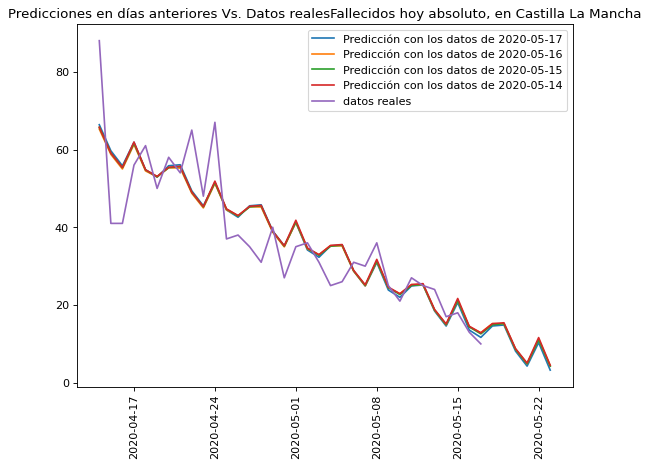

In [31]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_CM"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-21,10228.582696,141.393737,17229.825309,10228.582696,10228.582696,-1578.746952,-1578.746952,-1578.746952,-1578.746952,-1578.746952,-1578.746952,0.0,0.0,0.0,8649.835744
1,2020-03-22,10371.782277,0.000000,16290.080002,10371.782277,10371.782277,-2172.914282,-2172.914282,-2172.914282,-2172.914282,-2172.914282,-2172.914282,0.0,0.0,0.0,8198.867995
2,2020-03-23,10514.981857,4647.239347,21316.859022,10514.981857,10514.981857,2137.588506,2137.588506,2137.588506,2137.588506,2137.588506,2137.588506,0.0,0.0,0.0,12652.570364
3,2020-03-24,10658.181438,3798.738264,21169.619192,10658.181438,10658.181438,1461.951936,1461.951936,1461.951936,1461.951936,1461.951936,1461.951936,0.0,0.0,0.0,12120.133375
4,2020-03-25,10801.381019,3058.673270,19436.996837,10801.381019,10801.381019,708.818643,708.818643,708.818643,708.818643,708.818643,708.818643,0.0,0.0,0.0,11510.199662
5,2020-03-26,10944.580600,2671.148538,19610.383298,10944.580600,10944.580600,69.446133,69.446133,69.446133,69.446133,69.446133,69.446133,0.0,0.0,0.0,11014.026733
6,2020-03-27,11087.780181,2000.388520,19333.366633,11087.780181,11087.780181,-626.143985,-626.143985,-626.143985,-626.143985,-626.143985,-626.143985,0.0,0.0,0.0,10461.636196
7,2020-03-28,11230.979762,1430.905136,18127.039132,11230.979762,11230.979762,-1578.746952,-1578.746952,-1578.746952,-1578.746952,-1578.746952,-1578.746952,0.0,0.0,0.0,9652.232810
8,2020-03-29,11374.179343,257.934708,17417.149213,11374.179343,11374.179343,-2172.914282,-2172.914282,-2172.914282,-2172.914282,-2172.914282,-2172.914282,0.0,0.0,0.0,9201.265061
9,2020-03-30,11517.378924,4070.441444,21940.754715,11517.378924,11517.378924,2137.588506,2137.588506,2137.588506,2137.588506,2137.588506,2137.588506,0.0,0.0,0.0,13654.967430


Prediccion total para Hospitalizados : 4798989.472967147


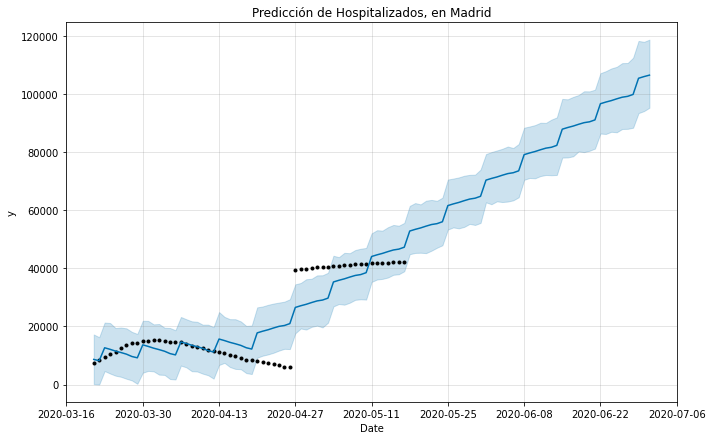

In [32]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Hospitalizados_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )

,Proporcion Curados hoy absoluto / Casos hoy absoluto,Moving Average (4) Proporcion Curados hoy absoluto / Casos hoy absoluto
Fecha,,
2020-03-12,0.000000,NaN
2020-03-13,0.000000,NaN
2020-03-16,0.000000,NaN
2020-03-17,0.000000,0.000000
2020-03-18,0.000000,0.000000
2020-03-19,0.000000,0.000000
2020-03-20,0.000000,0.000000
2020-03-21,0.000000,0.000000
2020-03-22,0.000000,0.000000


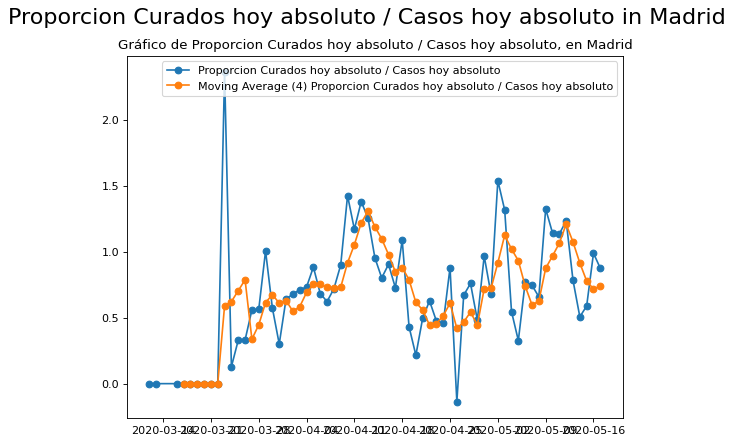

In [33]:
dimension = 'Proporcion Curados hoy absoluto / Casos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)


# ¿ Son reales estas cifras ? 
 
 Según reportaje de el mundo :https://www.elmundo.es/madrid/2020/04/07/5e8c427d21efa0b1668b45d6.html
 
   Entre los días 15 y 31 de marzo fallecieron en Madrid capital, "por todas las causas", aunque la mayoría por coronavirus, 5.950 personas, cuando en 2019, en el mismo lapso, murieron 1.100 personas

In [34]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)

Insertar_Enlace("Reales")

comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

madrid_muertos_segun_sanidad = comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

display(HTML ("Madrid muertos segun, <b>sanidad</b>, segunda quincena de Marzo:  <b>" + str(madrid_muertos_segun_sanidad)+"</b>"))

##

madrid_muertos_segun_interior = 5950 - 1100


display(HTML ("Madrid muertos segun, <b>interior</b>, mismo intervalo: <b>" + str(madrid_muertos_segun_interior)+"</b>"))


porcentaje_error = (madrid_muertos_segun_interior - madrid_muertos_segun_sanidad) / madrid_muertos_segun_sanidad


display(HTML ("La diferencia porcentual entre los muertos de sanidad e interior es de  <b>" + str(porcentaje_error) + "</b>") )

prediccion_muertos = comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error)



display(HTML ("El numero de <b>fallecidos en Madrid</b>, hasta ahora es de <b>" + str(comunidad['Fallecidos hoy absoluto'].sum()) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos)) + "</b> muertos" 
                                           ) )
Dimension = 'Fallecidos hoy absoluto'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)

total_muertos_españa = int(df['Total Fallecidos'].sum())
prediccion_muertos_españa = total_muertos_españa* (1+porcentaje_error)

display(HTML ("El numero de <b>fallecidos en España</b>, hasta ahora es de <b>" + str(total_muertos_españa) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos_españa)) + "</b> muertos"
                                           ))

In [35]:
from datetime import datetime

COMUNIDAD_A_CONSIDERAR = 'Madrid'
#comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)


comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

3522

Text(0.5, 1.0, 'Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior')

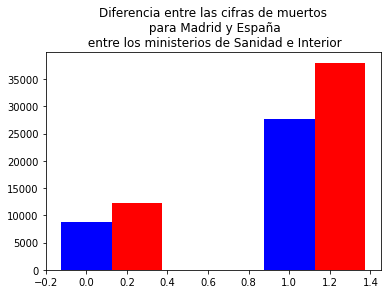

In [36]:
y = [comunidad['Fallecidos hoy absoluto'].sum(),total_muertos_españa]
z = [comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error), total_muertos_españa* (1+porcentaje_error)]

X = np.arange(2)

ax=plt.subplot(111)
plt.bar(X+0, y,color = 'b', width = 0.25)
plt.bar(X+0.25, z,color = 'r', width = 0.25)


ax.set_title("Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior")
